# Dask  Example 
## 2D advection equation

[Dask](http://dask.pydata.org/en/latest/) is a set of packages that lets you manually or automatically create task execution graphs, and then schedule them across threads, processes, or nodes.

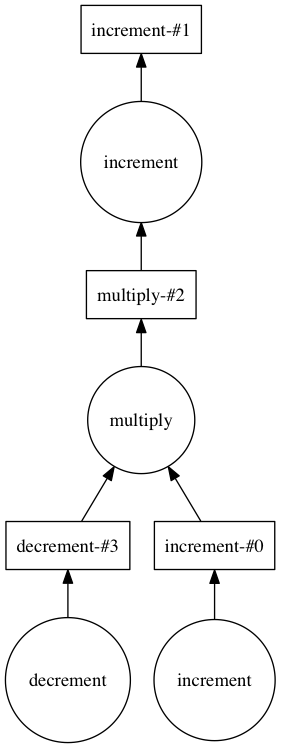

In [1]:
from dask import delayed, value

@delayed
def increment(x, inc=1):
    return x + inc

@delayed
def decrement(x, dec=1):
    return x - dec

@delayed
def multiply(x, factor):
    return x*factor

w = increment(1)
x = decrement(5)
y = multiply(w, x)
z = increment(y, 3)

from dask.dot import dot_graph
dot_graph(z.dask)

In [2]:
z.compute()

11

Dask is quite general purpose, and the task graph and scheduler supports data on disk, enabling out-of-core computation on data (which is going to be increasingly important as NVM becomes comomonplace. Although the dask scheduler is quite general purpose, much work has been put into building libraries for data frames and arrays.

Let's create a sizeable matrix and then operate on it using dask:

In [3]:
import h5py
import numpy as np 
import dask.array as da
import os

hdf_filename = 'data.h5'
try:
    os.remove(hdf_filename)
except OSError:
    pass

a = np.random.random(size=(5000,1000))
h5file = h5py.File(hdf_filename, 'w')
h5file.create_dataset('M', data=a)
h5file.close()

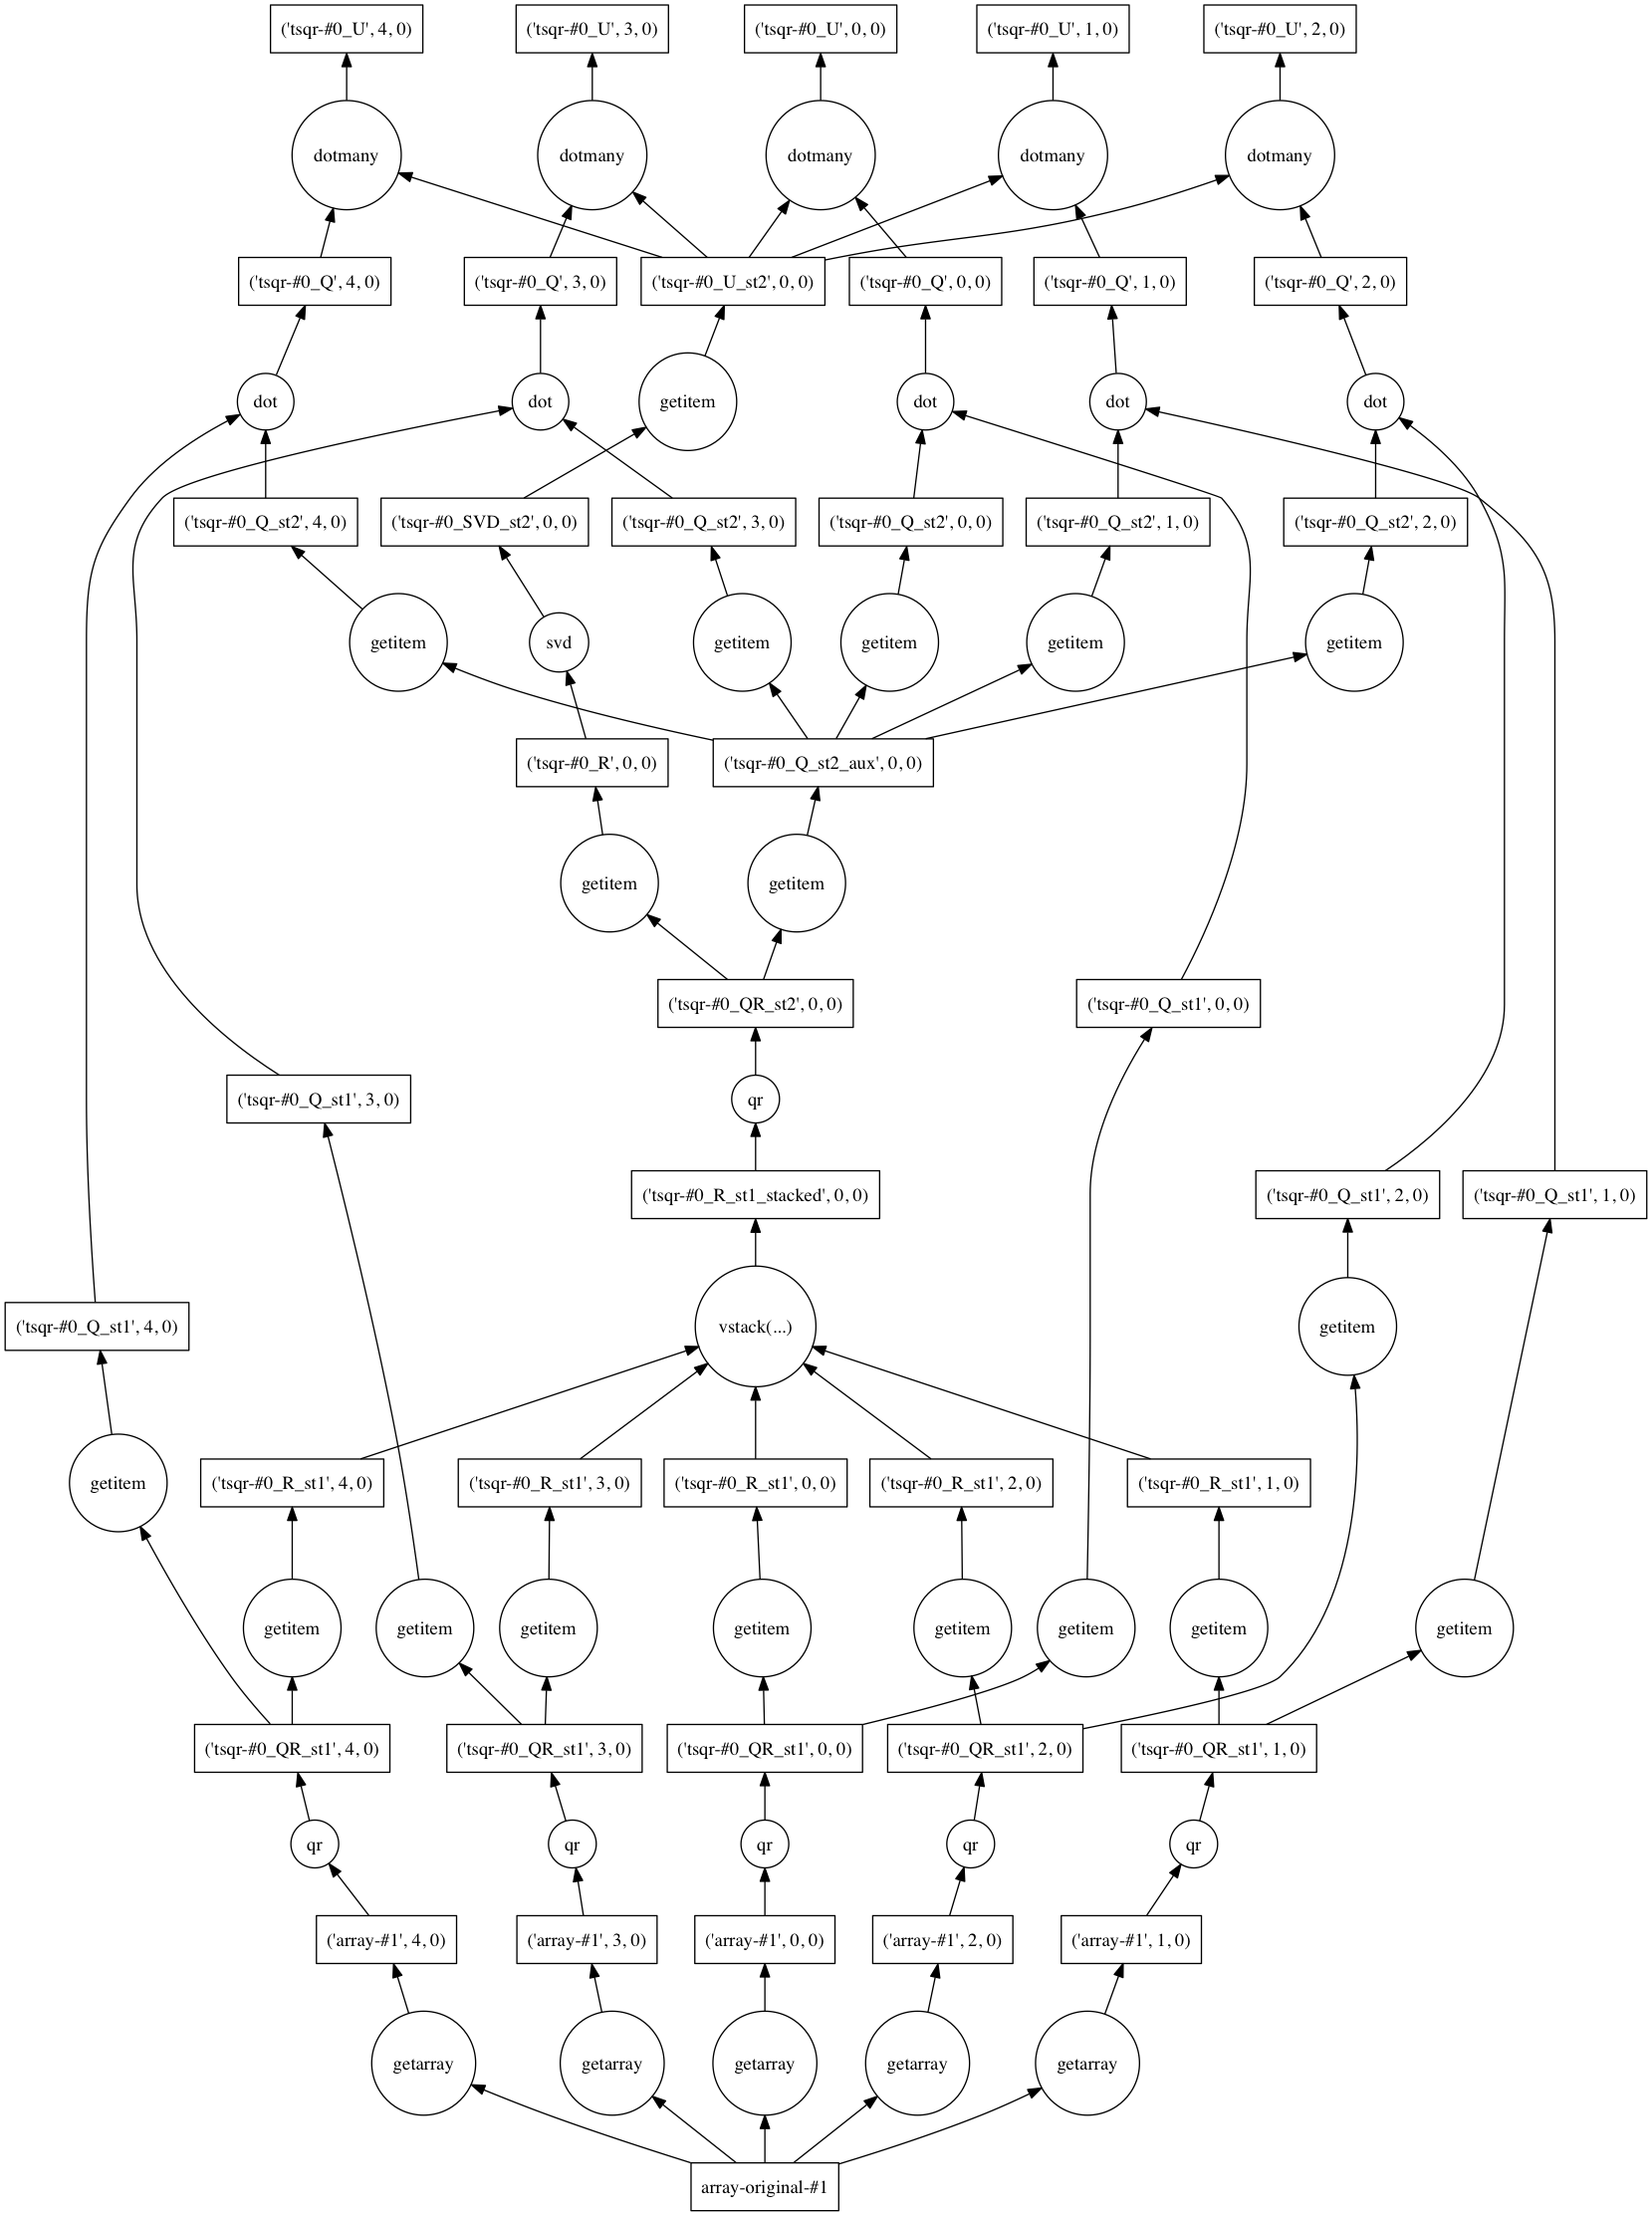

In [4]:
file = h5py.File(hdf_filename,'r')
mtx = da.from_array(file['/M'], chunks=(1000, 1000))
u, s, v = da.linalg.svd(mtx)
dot_graph(u.dask)

In [5]:
file.close()  # note we haven't actually run anything yet...

One common use case for scientific computing is for the data dependencies to be encapsulated in overlapping "ghost zones" in chunks of a dynamic array.  [Dask Arrays](http://dask.pydata.org/en/latest/array.html) have built in support for splitting numpy arrays between tasks and plotting such dependencies.

In [6]:
import matplotlib.pylab as plt


Let's set up a simple 2d advection problem, where we advect a little gaussian blob across a field:

In [7]:
npts = 51
x = np.arange(npts)/(npts-1)
y = np.arange(npts)/(npts-1)

def initial_conditions(x, y, initial_posx=0.3, initial_posy=0.3, sigma=0.15):
    """Returns a tuple describing the state at the point:
        (x, y, density(x,y))"""
    xx, yy = np.meshgrid(x,y)
    density = np.exp(-((xx-initial_posx)**2 + (yy-initial_posy)**2)/(sigma**2))
    return density

dens_init = initial_conditions(x, y)
subdomain_init = da.from_array(dens_init, chunks=((npts+1)//2, (npts+1)//2))

Let's make a routine for plotting:

In [8]:
import matplotlib.cm as cm
def plot_numpy_array(data, x, y, colorbar=False):
    extent = (min(x), max(x), min(y), max(y))
    levels = np.linspace(np.min(data), np.max(data), num=5)
    
    im = plt.imshow(data, interpolation='bilinear', origin='lower',
                    cmap=cm.Blues, extent=extent)
    if colorbar:
        plt.colorbar(im, orientation='vertical', shrink=0.8)
    plt.contour(x, y, data, levels, origin='lower', linewidths=2)
    
def plot_dask_array(dadata, x, y, colorbar=False):
    data = np.array(dadata)
    plot_numpy_array(data, x, y, colorbar)

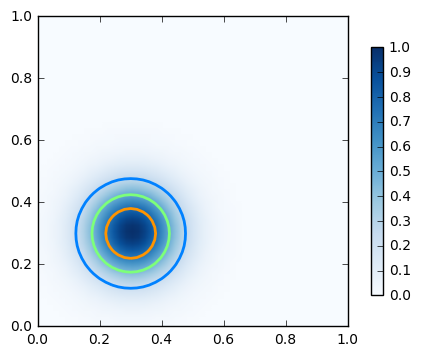

In [9]:
plot_numpy_array(dens_init, x, y, colorbar=True)
plt.show()

So far so good.  Now let's try writing our numerical method, a standard 2nd order upwind scheme:

In [10]:
u = np.array([1, 1])
speed = np.sqrt(np.dot(u,u))
cfl = 0.125

dx = x[1]-x[0]
dy = y[1]-y[0]
dt = cfl*min(dx,dy)/speed

def advect(subdomain, dx=dx, dy=dy, dt=dt, u=u):
    # second-order upwind
    gradx = np.zeros_like(subdomain)
    grady = np.zeros_like(subdomain)
    minold = np.min(subdomain)
    maxold = np.max(subdomain)
           
    if u[0] > 0:
        gradx[2:,:] = (3*subdomain[2:,:] - 4*subdomain[1:-1,:] + subdomain[:-2,:])/(2.*dx)
    else:
        gradx[:-2,:]= (-subdomain[2:,:] + 4*subdomain[1:-1,:] -3*subdomain[:-2,:])/(2.*dx)

    if u[1] > 0:
        grady[:,2:] = (3*subdomain[:,2:] - 4*subdomain[:,1:-1] + subdomain[:,:-2])/(2.*dy)
    else:
        grady[:,:-2]= (-subdomain[:,2:] + 4*subdomain[:,1:-1] -3*subdomain[:,:-2])/(2.*dy)

    return subdomain - dt*(u[0]*gradx + u[1]*grady)

Our method for implementing this with numpy with periodic boundary conditions will be to use guardcells (2 deep for the 2nd order upwind method):

In [11]:
def add_guardcells_periodic(subdomain, nguard=2):
    nx, ny = subdomain.shape
    with_guardcells = np.zeros((nx+2*nguard, ny+2*nguard)) + np.min(subdomain)
    with_guardcells[nguard:-nguard, nguard:-nguard] = subdomain
    with_guardcells[0:nguard, nguard:-nguard] = subdomain[-nguard:, :]
    with_guardcells[-nguard:, nguard:-nguard] = subdomain[0:nguard, :]
    with_guardcells[nguard:-nguard, 0:nguard] = subdomain[:, -nguard:]
    with_guardcells[nguard:-nguard, -nguard:] = subdomain[:, 0:nguard]
    return with_guardcells

def remove_guardcells(subdomain, nguard=2):
    return subdomain[nguard:-nguard, nguard:-nguard]

def numpy_step(subdomain, dx, dy, dt, u):
    return remove_guardcells(advect(add_guardcells_periodic(subdomain)))

Now let's try evolving this:

In [12]:
dens = dens_init
nsteps = 100
for step in range(0, nsteps):
    dens = numpy_step(dens, dx, dy, dt, u)
print("Evolved: {} units".format(dt*nsteps))

Evolved: 0.17677669529663687 units


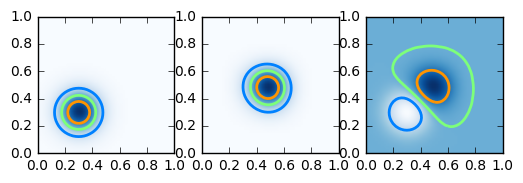

In [13]:
plt.subplots(1, 3)
plt.subplot(1, 3, 1)
plot_numpy_array(dens_init, x, y)
plt.subplot(1, 3, 2)
plot_numpy_array(dens, x, y)
plt.subplot(1, 3, 3)
plot_numpy_array(dens-dens_init, x, y)
plt.show()

Very nice.

Now let's try using dask arrays - the dask array has guardcell stuff built in:

In [14]:
def dask_step(subdomain, nguard=2):
    return subdomain.map_overlap(advect, depth=nguard, boundary='periodic')

Now let's try running this - dask has built-in routines for plotting usage:

In [15]:
from dask.diagnostics import ResourceProfiler, Profiler, ProgressBar, visualize
from dask.multiprocessing import get as mp_get
from bokeh.plotting import show as bpshow
from bokeh.io import output_notebook
from dask.multiprocessing import get as mp_get

with ResourceProfiler(0.5) as rprof, Profiler() as prof:
    subdomain = subdomain_init
    nsteps = 100
    for step in range(0, nsteps//2):
        subdomain = dask_step(subdomain)
    subdomain = subdomain.compute(num_workers=2, get=mp_get)
    
print("Evolved: {} units".format(dt*nsteps))
plots = visualize([prof, rprof], show=False)
output_notebook()
bpshow(plots)

Evolved: 0.17677669529663687 units


Loading BokehJS ...

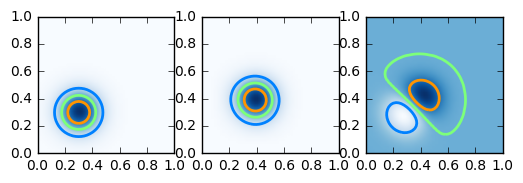

In [16]:
plt.subplots(1, 3)
plt.subplot(1, 3, 1)
plot_dask_array(subdomain_init, x, y)
plt.subplot(1, 3, 2)
plot_dask_array(subdomain, x, y)
plt.subplot(1, 3, 3)
plot_dask_array(subdomain-subdomain_init, x, y)
plt.show()